In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import numpy as np

import lightgbm
# import optuna.integration.lightgbm as lightgbm

In [3]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, OUT_MODEL_DIR, random_state
from utils.utils import *
from utils.load import load_data, save_file, save_model
from utils.cast_data import apply_datetime_format
from utils.plotting import *
from src.src import *

In [5]:
# Load data
df_w = load_data(file_name="df_weekly_896.csv", file_path=WORK_DATA_DIR)
data_dict = load_data(file_name="dict_weekly_896.pkl", file_path=WORK_DATA_DIR)

# Model features

In [8]:
# select model features
cols = [
    'vixo',
     # 'naaim_ind',
     'ff_M_RF',
     'ff_SMB',
     'ff_RMW',
     'ff_CMA',
    'ff_HML',
     'termspread',
     # 'pc_ratio',
     'aaii_Bullish',
    'sp_close',
    'sp_close_lag1',
    'sp_close_lag2',
    'sp_close_lag3',
    'sp_agg1',
    # 'goog_sent',
    # 'fears35'
]

In [9]:
df_ws = df_w[cols + [data_dict["predicted"]]].copy()

# Cross corr

In [10]:
df_cross_corr(df_ws,
              cols,
              # [item for item in cols if item not in data_dict["sp_cols"]],
              "sp_close_lead1",
              show_plot=False,
              no_lags=20,
              figsize=(6, 3))

[['vixo', 7, 0.084],
 ['ff_M_RF', 0, 0.076],
 ['ff_SMB', 16, 0.057],
 ['ff_RMW', 15, 0.091],
 ['ff_CMA', 15, 0.075],
 ['ff_HML', 5, 0.106],
 ['termspread', 13, 0.139],
 ['aaii_Bullish', 6, 0.083],
 ['sp_close', 9, 0.096],
 ['sp_close_lag1', 8, 0.096],
 ['sp_close_lag2', 7, 0.096],
 ['sp_close_lag3', 6, 0.096],
 ['sp_agg1', 12, 0.072]]

In [11]:
# df_ws = shift_var_relative_to_df(df_ws, shift_var=[# "vixo",
#                                                   ], no_lags=[
#     # 6
# ])

# Multi corr

,VIF,corr_sp_close_lead1
sp_close,2.639041,-0.088976
ff_M_RF,2.186277,-0.076074
sp_close_lag2,2.111739,-0.051383
termspread,1.075403,-0.028970
sp_agg1,3.580473,-0.026708
ff_CMA,1.249358,-0.004820
ff_HML,1.410757,0.007760
sp_close_lag3,1.883748,0.011537
sp_close_lag1,2.103737,0.017383
vixo,1.875840,0.025056


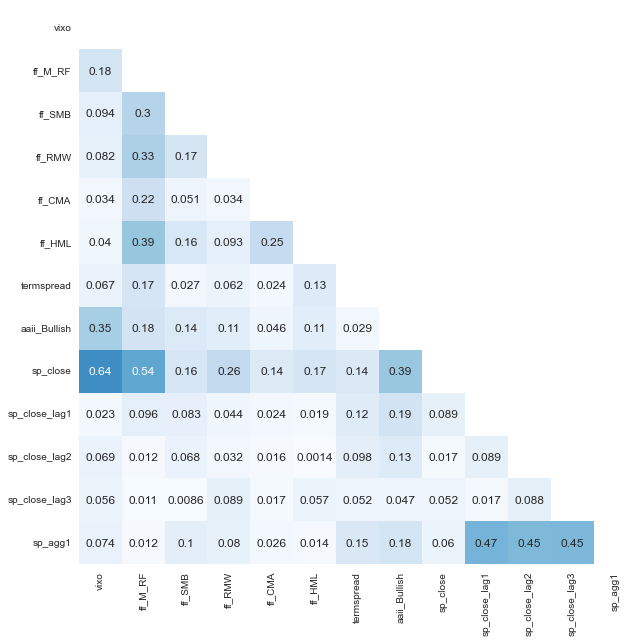

In [12]:
# only rely on correlation not vif
corr_heatmap(df_ws, 
             cols,
             show_fig=True)
get_variance_inflation_factor(df_ws, cols, col_pred=data_dict["predicted"])

# tts & standard scaling

In [13]:
df_train = df_ws.copy()

In [14]:
X_train, X_test, y_train, y_test = tts_data(df_train, y=data_dict["predicted"], x=cols, add_const=False, random_split=False, test_size=.2)

In [15]:
from sklearn.preprocessing import StandardScaler
scaler_x = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler_x.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler_x.transform(X_test), columns=X_test.columns)

# Model

In [59]:
lgb_train = lightgbm.Dataset(X_train, y_train)
lgb_eval = lightgbm.Dataset(X_test, y_test, reference=lgb_train)
evals_result = {} 

In [60]:
params = {
 'boosting_type': 'gbdt',
 'objective': 'regression',
 'metric': {'mean_squared_error', 'l2'},
 'num_leaves': 10,
 'learning_rate': 0.9,
 'feature_fraction': .99,
 'bagging_fraction': .99,
    'max_depth': -1,
 # 'bagging_freq': 4,
 # 'verbose': 20,
 # 'num_threads' : 10
}

In [61]:
%%capture
gbm_model = lightgbm.train(tuner.best_params,
                           lgb_train,
                           num_boost_round=250,
                           valid_sets=[lgb_eval, lgb_train],
                           callbacks=[lightgbm.early_stopping(100000), lightgbm.record_evaluation(evals_result)]
                          )

In [62]:
y_pred = gbm_model.predict(X_test, num_iteration=gbm_model.best_iteration)

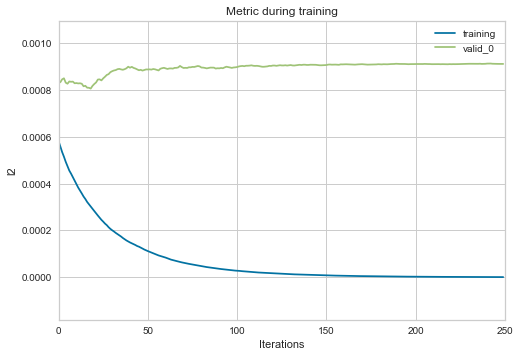

In [63]:
ax = lightgbm.plot_metric(evals_result)
plt.show()

mse: 0.0009115035472721173
mse: -0.09794345072913724


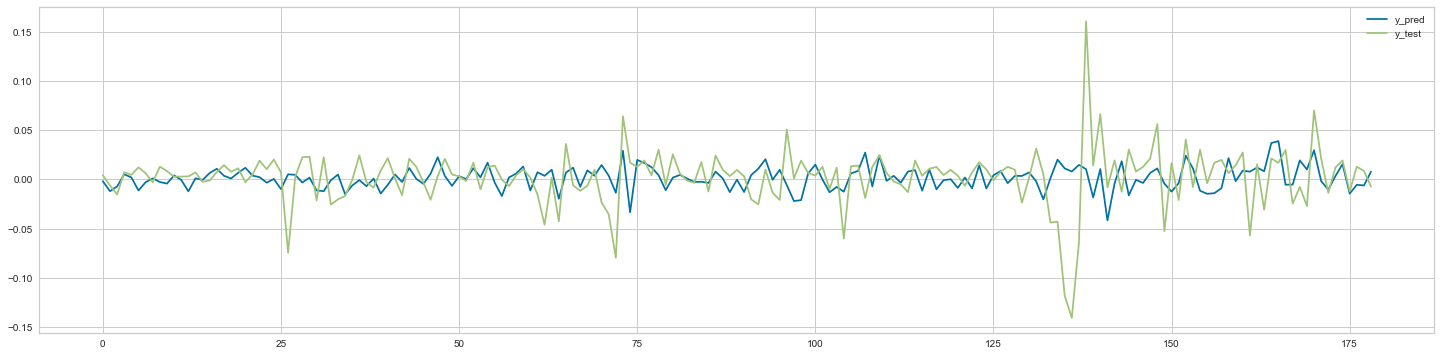

In [64]:
pred = gbm_model.predict(X_test, 
                         num_iteration=gbm_model.best_iteration
                        )

plt.figure(figsize=(25, 6))
plt.plot(pred)
plt.plot(y_test)
plt.legend(["y_pred", "y_test"])
from sklearn.metrics import mean_squared_error
print(f"mse: {mean_squared_error(y_test, pred)}")
print(f"mse: {r2_score(y_test, pred)}")

mse: 0.0008412383953717154
mse: -0.013306190046592725


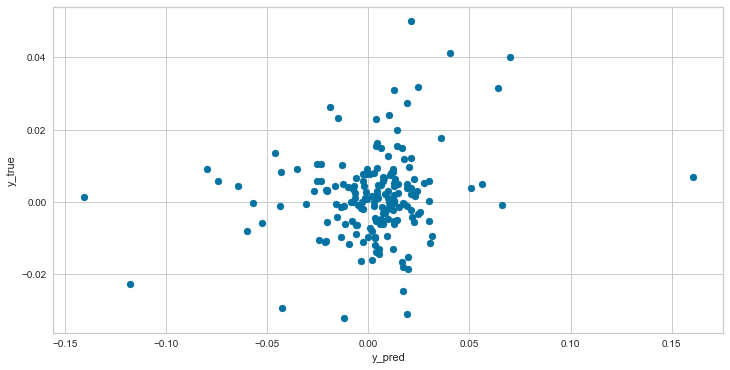

In [46]:
pred = gbm_model.predict(X_test, 
                         num_iteration=gbm_model.best_iteration
                        )

plt.figure(figsize=(12, 6))
plt.scatter(y_test, pred)
plt.xlabel("y_pred")
plt.ylabel("y_true")
from sklearn.metrics import mean_squared_error
print(f"mse: {mean_squared_error(y_test, pred)}")
print(f"mse: {r2_score(y_test, pred)}")

In [40]:
lgb_model = lightgbm.LGBMRegressor(random_state=random_state,
                                  # num_leaves=15, 
                                  #  max_depth=-1,
                                  #  learning_rate=.8,
                                  #  n_estimators=5,
                                  )

lgb_model.fit(X_train,
              y_train)

LGBMRegressor(random_state=101)

# Model eval

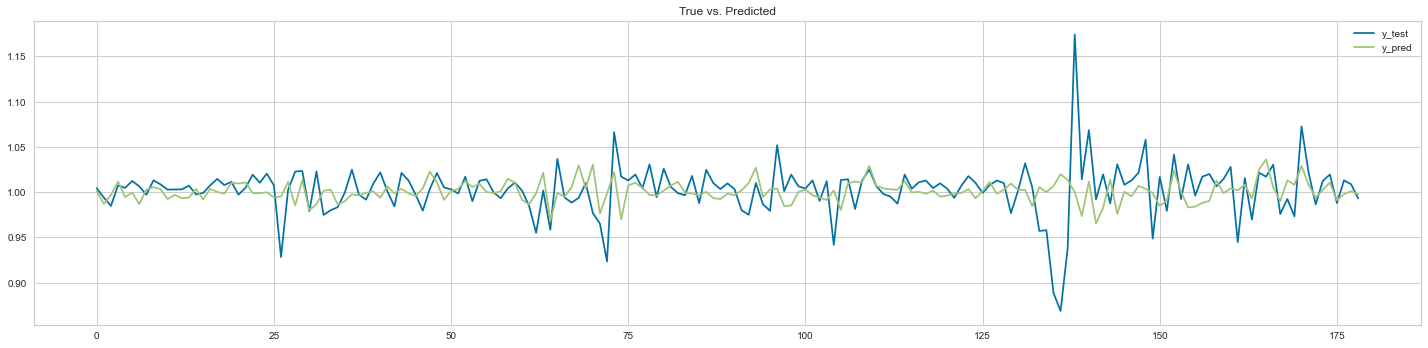

Validation Scores
mean squared error: 0.00091916
mean absolute error: 0.01964082
R2: -0.1096


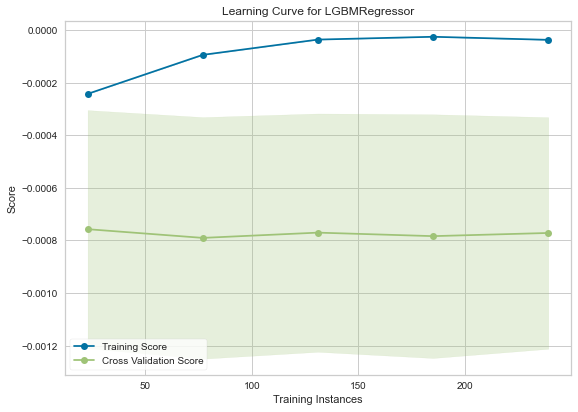

In [41]:
lgb_eval = ModelValidation(X_train=X_train,
                           y_train=y_train,
                           X_validate=X_test,
                           y_validate=y_test,
                           model=lgb_model,
                           data_dict=data_dict)

lgb_eval.get_model_performance()
# lgb_eval.analyse_resids(print_results=True)
lgb_eval.plot_learning_curve(n_splits=2, scoring="neg_mean_squared_error")
# lgb_eval.plot_results_on_price_scale(df_w,
                                     # df_ws,
                                     # xlim=[600, 700])

# Parameter tuning

In [53]:
import optuna.integration as opt
import optuna.integration.lightgbm as lgb_tuner
import optuna

import datetime as dt

In [54]:
tuner_params = {
    'objective': 'regression',
    'metric': ['mean_squared_error', 'l2'],
    'random_state': random_state
}

tuner_train = lightgbm.Dataset(X_train, y_train)
tuner_eval = lightgbm.Dataset(X_test, y_test, reference=lgb_train)
tuner_eval_results = {}
training_time = 60 * 100

In [55]:
my_study = optuna.study.create_study()

[I 2022-03-11 15:34:08,088] A new study created in memory with name: no-name-26a84e9c-9b70-4264-b51f-b98e679b61a0


In [56]:
%%capture
t_start = dt.datetime.now()
tuner = lgb_tuner.LightGBMTuner(tuner_params,
                                tuner_train,
                                valid_sets=tuner_eval,
                                study=my_study,
                                num_boost_round=1000,
                                time_budget=training_time,
                                callbacks=[lightgbm.early_stopping(10000), lightgbm.record_evaluation(tuner_eval_results)]
                               )
tuner.run()
t_end = dt.datetime.now()

[I 2022-03-11 15:34:09,470] Trial 0 finished with value: 0.0008189234968365652 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.0008189234968365652.
[I 2022-03-11 15:34:10,284] Trial 1 finished with value: 0.0008189234968365652 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.0008189234968365652.
[I 2022-03-11 15:34:11,109] Trial 2 finished with value: 0.0008189234968365652 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.0008189234968365652.
[I 2022-03-11 15:34:11,891] Trial 3 finished with value: 0.0008189234968365652 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.0008189234968365652.
[I 2022-03-11 15:34:12,713] Trial 4 finished with value: 0.0008189234968365652 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.0008189234968365652.
[I 2022-03-11 15:34:13,566] Trial 5 finished with value: 0.0008189234968365652 and parameters: {'feature_fraction': 1.0}

In [57]:
print(f'Parameters where tuned for {t_end - t_start}')
print(f'Max training time was {training_time}')

Parameters where tuned for 0:01:06.847444
Max training time was 6000


In [58]:
tuner.best_params

{'objective': 'regression',
 'metric': ['mean_squared_error', 'l2'],
 'random_state': 101,
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 31,
 'feature_fraction': 0.4,
 'bagging_fraction': 0.9368424479209843,
 'bagging_freq': 3,
 'min_child_samples': 10}

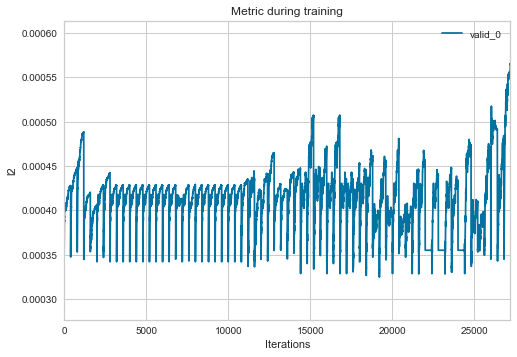

In [162]:
ax = lightgbm.plot_metric(tuner_eval_results, metric="l2")
plt.show()

In [163]:
my_study.best_trial

FrozenTrial(number=48, values=[0.0003249705921030805], datetime_start=datetime.datetime(2022, 3, 11, 13, 57, 18, 993052), datetime_complete=datetime.datetime(2022, 3, 11, 13, 57, 19, 437926), params={'lambda_l1': 0.005717591884514994, 'lambda_l2': 0.0006035760004713969}, distributions={'lambda_l1': LogUniformDistribution(high=10.0, low=1e-08), 'lambda_l2': LogUniformDistribution(high=10.0, low=1e-08)}, user_attrs={}, system_attrs={'lightgbm_tuner:elapsed_secs': 0.4418830871582031, 'lightgbm_tuner:average_iteration_time': 0.03399100670447716, 'lightgbm_tuner:step_name': 'regularization_factors', 'lightgbm_tuner:lgbm_params': '{"objective": "regression", "metric": ["mean_squared_error", "l2"], "random_state": 101, "feature_pre_filter": false, "lambda_l1": 0.005717591884514994, "lambda_l2": 0.0006035760004713969, "num_leaves": 31, "feature_fraction": 0.7, "bagging_fraction": 0.5023747603769716, "bagging_freq": 6, "min_child_samples": 20}'}, intermediate_values={}, trial_id=48, state=Trial

In [164]:
tuner.best_params

{'objective': 'regression',
 'metric': ['mean_squared_error', 'l2'],
 'random_state': 101,
 'feature_pre_filter': False,
 'lambda_l1': 0.005717591884514994,
 'lambda_l2': 0.0006035760004713969,
 'num_leaves': 31,
 'feature_fraction': 0.7,
 'bagging_fraction': 0.5023747603769716,
 'bagging_freq': 6,
 'min_child_samples': 20}